In [1]:
import sys

sys.path.append("../")

from depo.functions import Functions as func

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dttt1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# -------------------------- LIBRARIES NECESSARY IN THIS PROJECT  -------------------------- #
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import xgboost as xgb

import pandas as pd

# DataSet extraction and global features declaration

In [3]:
# -------------------------- PATH OF THE DATASETS USED IN THE PROJECT  -------------------------- #

# Defines the Date format
dateFormat='%Y-%m-%d'

# -------------------------- PATH OF THE DATASETS USED IN THE PROJECT  -------------------------- #
df_retails = func.open_file('dataSets.zip/online_retail_II.csv')

# Data normalization

In [4]:
df_retails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [5]:
df_retails.rename(columns={'Invoice':'InvoiceNo', 'Customer ID':'CustomerID', 'Price':'UnitPrice'}, inplace=True)

# Checks the percentage of NaN values in the dataSet
df_retails.print_nan_columns()

,Missing Values,% Missing Values,Zero Values,% Missing Values,Zero Missing Values,% Zero Missing Values,Data Type
CustomerID,243007,22.77,0,0.00,243007,22.77,float64
Description,4382,0.41,0,0.00,4382,0.41,object
InvoiceNo,0,0.00,0,0.00,0,0.00,object
StockCode,0,0.00,0,0.00,0,0.00,object
Quantity,0,0.00,0,0.00,0,0.00,int64
InvoiceDate,0,0.00,0,0.00,0,0.00,object
UnitPrice,0,0.00,6202,0.58,6202,0.58,float64
Country,0,0.00,0,0.00,0,0.00,object
Total,247389,23.18,6202,0.58,253591,23.76,-


<AxesSubplot:>

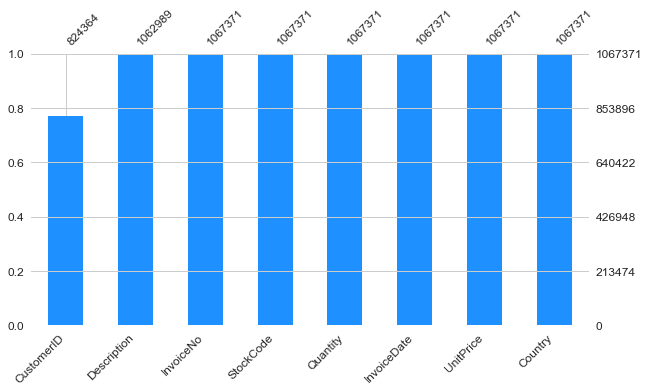

In [6]:
df_retails.print_nan_bar_chart()

<AxesSubplot:>

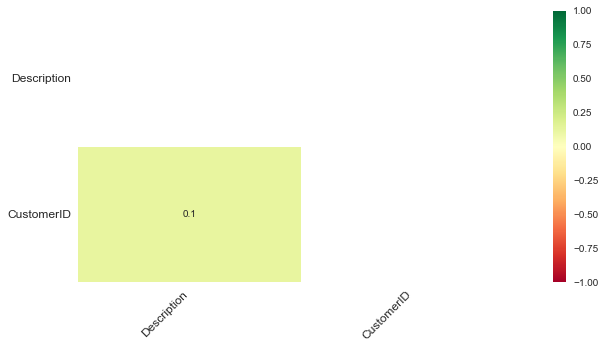

In [7]:
# Checks the relationship of the NaN columns
df_retails.print_nan_heat_map()

<AxesSubplot:>

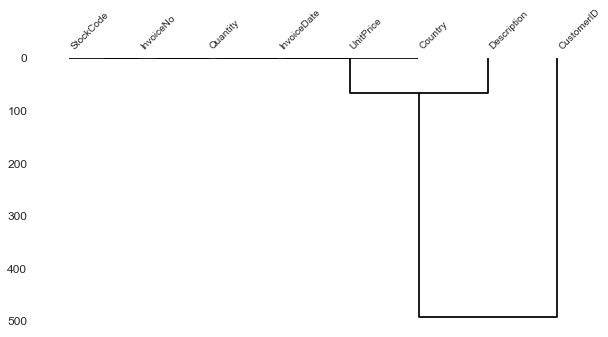

In [8]:
# Checks the relationship of the NaN columns
df_retails.print_nan_dendrogram()

### The graph Dendrogram shows a relationship from UnitPrice and Country when Description is NaN, so let's plot a Matrix graph to have an overview of these data.

<AxesSubplot:>

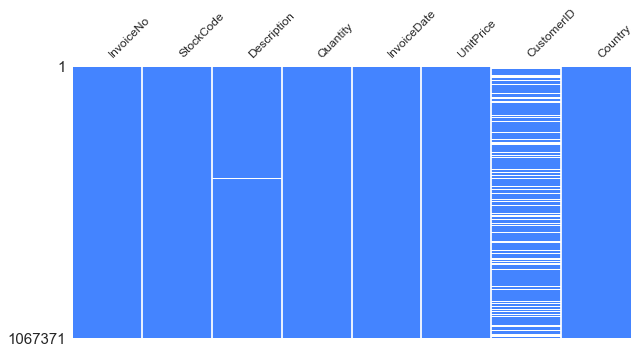

In [9]:
# Plots a matrix graph to have an overview of the dataSet
df_retails.print_nan_matrix()

### As shown though the Matrix above, UnitPrice and Country are not NaN Columns, so their influences in Description is not because they might be NaN

In [10]:
# Prints the data with Description null
df_temp = df_retails.copy()
df_where = df_temp[{"InvoiceNo", "UnitPrice", "Country"}].loc[df_temp["Description"].isnull()]
df_where.drop_duplicates(subset = ["UnitPrice", "Country"])

,UnitPrice,Country,InvoiceNo
470,0.00,United Kingdom,489521


In [11]:
# The Description Nan are from the same invoice, which has an UnitPrice 0, which should be ok to delete
# Nan Descriptions
df_retails.dropna(subset = ["Description"], inplace=True)

In [12]:
# Prints the data with CustomerID null
df_temp = df_retails.copy()
df_where = df_temp[{"StockCode", "InvoiceNo", "Description"}].loc[df_temp["CustomerID"].isnull()]
df_where.drop_duplicates(subset = ["StockCode", "InvoiceNo", "Description"])

,Description,StockCode,InvoiceNo
263,85123a mixed,21733,489464
283,short,71477,489463
284,21733 mixed,85123A,489467
577,BLUE PULL BACK RACING CAR,85226C,489525
578,SET/6 3D KIT CARDS FOR KIDS,85227,489525
...,...,...,...
1066997,JUMBO BAG RED RETROSPOT,85099B,581498
1066998,JUMBO BAG BAROQUE BLACK WHITE,85099C,581498
1066999,LADIES & GENTLEMEN METAL SIGN,85150,581498
1067000,S/4 CACTI CANDLES,85174,581498


In [13]:
# An analyse in the dataSet given doest show much the reason of CustomerID be NaN, so these data are deleted
#  To dont have impact in the results
df_retails.dropna(subset = ["CustomerID"], inplace=True)

# Converts Column InvoiceDate to DateTime
#df_retails['InvoiceDate'] = f.f_FormatToDate(df_retails['InvoiceDate'], dateFormat)

df_retails['InvoiceDate'] = pd.to_datetime(df_retails.InvoiceDate)

df_retails.InvoiceDate.describe()

count                  824364
unique                  41439
top       2011-11-14 15:27:00
freq                      543
first     2009-12-01 07:45:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [14]:
# Calculates a column Revenue, which is UnitPrice of a purchase  * Quantity purchased
df_retails['Revenue'] = df_retails.UnitPrice * df_retails.Quantity
df_retails.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom,30.00


In [15]:
# Gets last date ever of purchase
#LastPurchaseDayMAX = df_retails.InvoiceDate.max()
#LastPurchaseDayMAX = f.f_GetLastDayOfMonth(LastPurchaseDayMAX)
#LastPurchaseDayMAX = LastPurchaseDayMAX - timedelta(30)

LastPurchaseDayMAX = pd.Timestamp(2011,12,1)

# Gets the 90 days from the last purchase
#LastPurchaseDayMIN = LastPurchaseDayMAX - timedelta(91)
LastPurchaseDayMIN = pd.Timestamp(2011,9,1)

# Gets just purchase done in the last 90 days
df_PurchaseLast90Days = df_retails[
                                    (df_retails.InvoiceDate >= LastPurchaseDayMIN)
                                  & (df_retails.InvoiceDate < LastPurchaseDayMAX)

                                  ].groupby(['CustomerID', 'InvoiceDate']).agg({"UnitPrice": "sum"}).reset_index()

In [16]:
# Gets first date of purchase
#FirstPurchaseDayMIN = df_retails.InvoiceDate.min()
# Gets last date of purchase before the last 90 days
#FirstPurchaseDayMAX = LastPurchaseDayMIN

FirstPurchaseDayMIN = pd.Timestamp(2009,12,1)
FirstPurchaseDayMAX = pd.Timestamp(2011,9,1)

# Gets just purchase done before the last 90 days
df_PurchaseBeforeLast90Days = df_retails[
                                    (df_retails.InvoiceDate >= FirstPurchaseDayMIN)
                                  & (df_retails.InvoiceDate < FirstPurchaseDayMAX)

                                  ].groupby(['CustomerID', 'InvoiceDate']).agg({"UnitPrice": "sum"}).reset_index()

In [17]:
# Gets all customers in the dataset
df_customers = pd.DataFrame(data = df_PurchaseBeforeLast90Days['CustomerID'].unique()
                          , columns = ['CustomerID'])

In [18]:
# Creates a data frame with the first purchase date distincted by customer
df_firstPurchaseDate = pd.DataFrame(data=df_PurchaseBeforeLast90Days.groupby('CustomerID').InvoiceDate.max().reset_index())

# Renames the column InvoiceDate to FirstPurchaseDate
df_firstPurchaseDate = df_firstPurchaseDate.rename(columns={'InvoiceDate':'MaxPurchaseDate'})

In [19]:
# Creates a data frame with the last purchase date distincted by customer
df_lastPurchaseDate = pd.DataFrame(data=df_PurchaseLast90Days.groupby('CustomerID').InvoiceDate.min().reset_index())

# Renames the column InvoiceDate to LastPurchaseDate
df_lastPurchaseDate = df_lastPurchaseDate.rename(columns={'InvoiceDate':'MinPurchaseDate'})

In [20]:
# Merges data frames with first and last purchase dates                                
df_datesMerged = df_firstPurchaseDate.merge(df_lastPurchaseDate, how = 'left')

In [21]:
# Gets the difference beetween the Last Purchase date and First Purchase date, and insert it in a column called NextPurchaseDay
df_datesMerged['NextPurchaseDay'] = (df_datesMerged['MinPurchaseDate']
                                   - df_datesMerged['MaxPurchaseDate']).dt.days

# Merges the NextPurchaseDay in the dataframe df_customers
df_customerDates = df_customers.merge(df_datesMerged[['CustomerID', 'NextPurchaseDay']]
                                    , on='CustomerID'
                                    , how = 'left')

# Fills 9999 whether NextPurchaseDay is null
df_customerDates = df_customerDates.fillna(9999)

# Feature Engineering

## Recency

In [22]:
# Creates a new dataframe by CustomerID grouped by their last purchase date
df_recency = pd.DataFrame(data=df_firstPurchaseDate.groupby('CustomerID').MaxPurchaseDate.max().reset_index())

# Creates a column called Recency, which represents the last purchase date of a customers
# It indicates how recente a customer has made his last purchase
df_recency['Recency'] = (df_recency['MaxPurchaseDate'].max()
                       - df_recency['MaxPurchaseDate']).dt.days

# Merges the main dataframe with the Recency dataframe
df_customerDates = df_customerDates.merge(df_recency[['CustomerID', 'Recency']]
                                        , on='CustomerID')

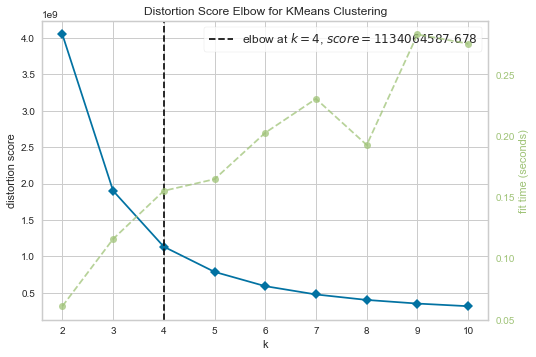

In [23]:
# Next step is applying K-means clustering to group by Recency from CustomerID
# But Before It is applyed the elbow method to get the number of clusters

# dataSet with CustomerID and Recency
X = df_recency[{'CustomerID', 'Recency'}]

# From 2 to 10 clusters
k=(1,10)

# Prints Elbow graph
X.print_elbow(k)

In [24]:
# Applys KMeans of 4 clusters in Recency column
X = df_customerDates[['Recency']]

df_customerDates['RecencyCluster'] = KMeans(4).fit(X).predict(X)
df_customerDates.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster
0,12346.00,9999.00,225,0
1,12347.00,90.00,29,2
2,12348.00,173.00,148,0
3,12349.00,389.00,307,1
4,12350.00,9999.00,210,0


In [25]:
# Order by RecencyCluster
df_customerDates = df_customerDates.order_cluster('Recency', 'RecencyCluster', False)
df_customerDates.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster
0,12346.00,9999.00,225,2
1,12348.00,173.00,148,2
2,12350.00,9999.00,210,2
3,12352.00,181.00,162,2
4,12353.00,9999.00,103,2


In [26]:
#print cluster characteristics
df_customerDates.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,750.00,520.51,65.22,418.00,465.00,517.00,571.50,638.00
1,1427.00,314.36,41.13,236.00,281.50,308.00,338.00,416.00
2,1121.00,154.56,39.69,96.00,117.00,152.00,185.00,234.00
3,2016.00,37.41,27.26,0.00,13.00,33.00,58.00,94.00


As shown the curster 3 covers most of the recent customers

## Frequency

In [27]:
# Gets the counts of purchase for each user
df_frequency = df_retails.groupby('CustomerID').InvoiceDate.count().reset_index()
df_frequency.columns = ['CustomerID', 'Frequency']

# Merges the main dataframe with the Recency dataframe
df_customerDates = df_customerDates.merge(df_frequency
                                        , on='CustomerID')

df_customerDates.head()                                       

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,12346.00,9999.00,225,2,48
1,12348.00,173.00,148,2,51
2,12350.00,9999.00,210,2,17
3,12352.00,181.00,162,2,113
4,12353.00,9999.00,103,2,24


In [28]:
# Checks the details of each cluster
df_customerDates.Frequency.describe()

count    5314.00
mean      149.50
std       378.18
min         1.00
25%        22.00
50%        59.00
75%       158.75
max     13097.00
Name: Frequency, dtype: float64

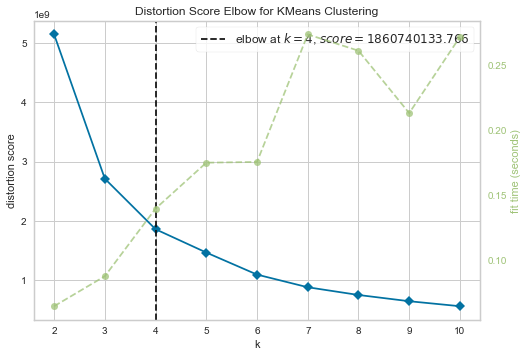

In [29]:
# Applies the elbow method to get the number of clusters

# dataSet with CustomerID and Recency
X = df_frequency[{'CustomerID', 'Frequency'}]

# From 2 to 10 clusters
k=(1,10)

# Prints Elbow graph
X.print_elbow(k)

In [30]:
# Applys KMeans of 4 clusters in Frequency column
X = df_customerDates[['Frequency']]

df_customerDates['FrequencyCluster'] = KMeans(4).fit(X).predict(X)

In [31]:
# Order by RecencyCluster
df_customerDates = df_customerDates.order_cluster('Frequency', 'FrequencyCluster', False)
df_customerDates.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster
0,12346.00,9999.00,225,2,48,3
1,12348.00,173.00,148,2,51,3
2,12350.00,9999.00,210,2,17,3
3,12352.00,181.00,162,2,113,3
4,12353.00,9999.00,103,2,24,3


In [32]:
# Checks the details of each cluster
df_customerDates.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,2.00,12355.00,1049.35,11613.00,11984.00,12355.00,12726.00,13097.00
1,14.00,3921.00,1541.06,2430.00,2829.50,3346.50,4570.25,7307.00
2,404.00,716.73,318.76,403.00,482.75,604.00,844.50,2134.00
3,4894.00,86.90,91.18,1.00,20.00,51.00,123.00,402.00


## Revenue

In [33]:
# Gets the Sum of the purchase value for each user
df_Revenue = df_retails.groupby('CustomerID').Revenue.sum().reset_index()
df_Revenue.columns = ['CustomerID', 'Revenue']

# Merges the main dataframe with the Recency dataframe
df_customerDates = df_customerDates.merge(df_Revenue[['CustomerID', 'Revenue']]
                                        , on='CustomerID')
df_customerDates.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,12346.00,9999.00,225,2,48,3,-64.68
1,12348.00,173.00,148,2,51,3,2019.40
2,12350.00,9999.00,210,2,17,3,334.40
3,12352.00,181.00,162,2,113,3,1889.21
4,12353.00,9999.00,103,2,24,3,406.76


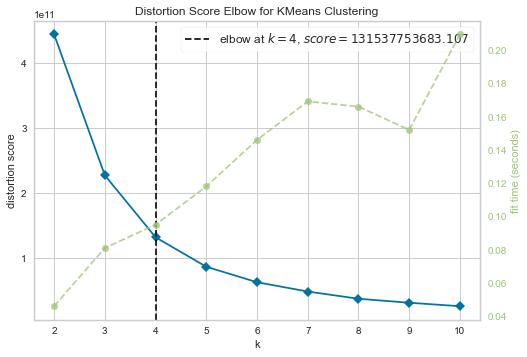

In [34]:
# Applies the elbow method to get the number of clusters

# dataSet with CustomerID and Recency
X = df_Revenue[{'CustomerID', 'Revenue'}]

# From 2 to 10 clusters
k=(1,10)

# Prints Elbow graph
X.print_elbow(k)

In [35]:
# Applys KMeans of 4 clusters in Revenue column
X = df_customerDates[['Revenue']]

df_customerDates['RevenueCluster'] = KMeans(4).fit(X).predict(X)
df_customerDates.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,12346.00,9999.00,225,2,48,3,-64.68,0
1,12348.00,173.00,148,2,51,3,2019.40,0
2,12350.00,9999.00,210,2,17,3,334.40,0
3,12352.00,181.00,162,2,113,3,1889.21,0
4,12353.00,9999.00,103,2,24,3,406.76,0


In [36]:
# Orders the cluster numbers
df_customerDates = df_customerDates.order_cluster('Revenue', 'RevenueCluster', True)
df_customerDates.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,12346.00,9999.00,225,2,48,3,-64.68,0
1,12348.00,173.00,148,2,51,3,2019.40,0
2,12350.00,9999.00,210,2,17,3,334.40,0
3,12352.00,181.00,162,2,113,3,1889.21,0
4,12353.00,9999.00,103,2,24,3,406.76,0


In [37]:
# Checks the details of each cluster
df_customerDates.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,5239.00,2029.77,3092.14,-25111.09,344.67,924.36,2327.09,23090.47
1,65.00,44586.32,22598.24,23350.74,26960.02,35866.63,55703.13,113513.07
2,8.00,198033.39,62010.60,136391.48,142827.53,181355.75,242746.67,296564.69
3,2.00,560778.65,52943.31,523342.07,542060.36,560778.65,579496.93,598215.22


## Overall Score

In [38]:
# Calculates the overall score 
df_customerDates['OverallScore'] = (df_customerDates['RecencyCluster']
                                  + df_customerDates['FrequencyCluster']
                                  + df_customerDates['RevenueCluster'])

# Get mean (Average) of Recency, Frequency, Revenue grouped by OverallScore
df_customerDates.groupby('OverallScore')['Recency', 'Frequency', 'Revenue'].mean()                                  

,Recency,Frequency,Revenue
OverallScore,,,
3,514.61,39.93,435.11
4,309.11,94.88,1203.62
5,126.64,259.58,3777.65
6,39.58,148.91,3588.25
7,15.00,614.71,95521.63
8,26.00,1068.00,598215.22


### The scoring above shows that the customer who has overall score 8 are the ones who last bought, those who buy with more frequency, and those who spend higher Over the others.

In [39]:
# Categories customers' into Segement based on their OverallScore

# Initially, giving 'Low-Value' for all 
df_customerDates['Segment'] = 'Low-Value'

# 'Mid-Value' for those with OverallScore higher than 4
df_customerDates.loc[df_customerDates['OverallScore'] > 4, 'Segment'] = 'Mid-Value'

# and 'High-Value' with those with Overall Score higher than 6
df_customerDates.loc[df_customerDates['OverallScore'] > 6, 'Segment'] = 'High-Value'

df_customerDates.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,12346.00,9999.00,225,2,48,3,-64.68,0,5,Mid-Value
1,12348.00,173.00,148,2,51,3,2019.40,0,5,Mid-Value
2,12350.00,9999.00,210,2,17,3,334.40,0,5,Mid-Value
3,12352.00,181.00,162,2,113,3,1889.21,0,5,Mid-Value
4,12353.00,9999.00,103,2,24,3,406.76,0,5,Mid-Value


In [40]:
# Converts all categories as classes
df_customerClasses = pd.get_dummies(df_customerDates)
df_customerClasses.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,12346.00,9999.00,225,2,48,3,-64.68,0,5,0,0,1
1,12348.00,173.00,148,2,51,3,2019.40,0,5,0,0,1
2,12350.00,9999.00,210,2,17,3,334.40,0,5,0,0,1
3,12352.00,181.00,162,2,113,3,1889.21,0,5,0,0,1
4,12353.00,9999.00,103,2,24,3,406.76,0,5,0,0,1


In [41]:
# Sets a column called 'Target' to 1. This colums will indicate whether a customer will purchase in the next 90 days

# Initially It is said all customers will buy in the next 90 days
df_customerClasses['Target'] = 1 

# Assignes 0 to those who do not suppose to buy in the next quarter
df_customerClasses.loc[df_customerClasses.NextPurchaseDay > 90, 'Target'] = 0

df_customerClasses.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,Target
0,12346.00,9999.00,225,2,48,3,-64.68,0,5,0,0,1,0
1,12348.00,173.00,148,2,51,3,2019.40,0,5,0,0,1,0
2,12350.00,9999.00,210,2,17,3,334.40,0,5,0,0,1,0
3,12352.00,181.00,162,2,113,3,1889.21,0,5,0,0,1,0
4,12353.00,9999.00,103,2,24,3,406.76,0,5,0,0,1,0


In [42]:
#df_corrMatrix = f.GetCorrelationMatrix(df_customerClasses)
#print(df_corrMatrix)

In [43]:
#f.PlotHeatMap(df_corrMatrix)

In [44]:
# The columns NextPurchaseDay was used to estimate whether a customer will make a purchase, and will not be used in the next step, so It is droped from the dataframe
df_customerClasses = df_customerClasses.drop('NextPurchaseDay', axis=1)
df_customerClasses.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,Target
0,12346.00,225,2,48,3,-64.68,0,5,0,0,1,0
1,12348.00,148,2,51,3,2019.40,0,5,0,0,1,0
2,12350.00,210,2,17,3,334.40,0,5,0,0,1,0
3,12352.00,162,2,113,3,1889.21,0,5,0,0,1,0
4,12353.00,103,2,24,3,406.76,0,5,0,0,1,0


# Machine Learning Models

In [45]:
X, y = df_customerClasses.drop('Target', axis=1), df_customerClasses.Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)

In [50]:
func.print_models_scores(X_train, X_test, y_train, y_test)

 90%|█████████ | 27/30 [00:04<00:00,  6.29it/s]

[20:27:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 30/30 [00:05<00:00,  5.25it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
QuadraticDiscriminantAnalysis      0.84               0.89     0.89      0.86   
PassiveAggressiveClassifier        0.83               0.89     0.89      0.85   
GaussianNB                         0.82               0.89     0.89      0.84   
SGDClassifier                      0.89               0.89     0.89      0.90   
NearestCentroid                    0.80               0.87     0.87      0.82   
AdaBoostClassifier                 0.91               0.86     0.86      0.91   
LogisticRegressionCV               0.91               0.86     0.86      0.91   
SVC                                0.92               0.86     0.86      0.91   
LogisticRegression                 0.91               0.86     0.86      0.91   
LinearSVC                          0.91               0.86     0.86      0.91   
Perceptron                  

In [57]:
from sklearn.ensemble import AdaBoostClassifier

models = {
    'AdaBoostClassifier': AdaBoostClassifier()
}

params = {
    'AdaBoostClassifier':  { 'n_estimators': [16, 32] }
}

In [58]:
func.get_grid_searchCV_scores(models, params,  X_train, y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
            estimator min_score mean_score max_score std_score n_estimators
1  AdaBoostClassifier      0.90       0.91      0.91      0.01           32
0  AdaBoostClassifier      0.89       0.90      0.91      0.01           16


In [49]:
#func.print_balanded_models_scores(X_train, y_train) 